# Hierarchical Models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pymc-labs/ai_decision_workshop/blob/main/notebooks/03_hierarchical.ipynb)

In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

plt.rcParams['figure.dpi'] = 75
plt.rcParams['figure.figsize'] = (6.4, 3.2)

In [2]:
def plot_prior(trace, **options):
    return pm.plot_posterior(trace, group='prior', **options);

In [3]:
def plot_posterior_predictive(trace, **options):
    return pm.plot_posterior(trace, group='posterior_predictive', **options);

In [4]:
def run_samplers(model, *args, **options):
    with model:
        # Sample the prior predictive
        prior_pred = pm.sample_prior_predictive()

        # Sample from the posterior
        trace = pm.sample(*args, **options)

        # Sample from the posterior predictive
        posterior_pred = pm.sample_posterior_predictive(trace)

    trace.extend(prior_pred)
    trace.extend(posterior_pred)
    
    return trace

In [5]:
from scipy.stats import binom

def run_campaign(d, n=100):
    d['n'] += n
    d['k'] += binom.rvs(n=n, p=d['p'])

## Bandits Revisited

Continuing the A/B testing example from the previous notebook, suppose we have an old email we have sent 200 times.

In [6]:
np.random.seed(1)

In [7]:
A = dict(p=0.1, n=0, k=0)
run_campaign(A, 200)
A

{'p': 0.1, 'n': 200, 'k': 19}

In [8]:
obs_proportion_A = A['k'] / A['n']
obs_proportion_A

0.095

And a new version we have sent only 10 times, where the actual probability of conversion is 25%, close to the prior mean.

In [9]:
B = dict(p=0.25, n=0, k=0)
run_campaign(B, 10)
B

{'p': 0.25, 'n': 10, 'k': 3}

In [10]:
obs_proportion_B = B['k'] / B['n']
obs_proportion_B

0.3

Here's the model that estimates conversion rates for A and B.

In [11]:
with pm.Model() as model_AB:
    # Priors for conversion rates of A and B
    conversion_rate_A = pm.Beta("conversion_rate_A", alpha=2, beta=5)
    conversion_rate_B = pm.Beta("conversion_rate_B", alpha=2, beta=5)
    
    # Likelihoods for observed data
    obs_A = pm.Binomial("obs_A", p=conversion_rate_A, n=A['n'], observed=A['k'])
    obs_B = pm.Binomial("obs_B", p=conversion_rate_B, n=B['n'], observed=B['k'])
    
    trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_A, conversion_rate_B]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Here are the posterior distributions, showing the observed proportions as reference values.

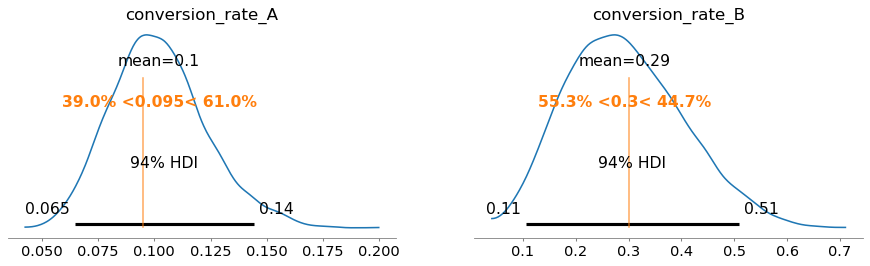

In [12]:
ref_val = [obs_proportion_A, obs_proportion_B]
pm.plot_posterior(trace, ref_val=ref_val);

In this model, the conversion rates are independent -- the data from A doesn't affect the posterior distribution for B, and vice versa.

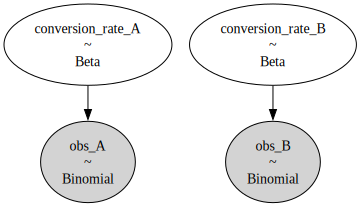

In [13]:
pm.model_to_graphviz(model_AB)

And that means we are leaving information on the table: because A and B are similar, what we learn about A gives us information about the effectiveness of campaigns like this in general, which influences what we should believe about B.

We can take advantage of this additional information by making the model hierarchical.

In [14]:
# Modify this

with pm.Model() as model_hierarchical:
    # Priors for conversion rates of A and B
    conversion_rate_A = pm.Beta("conversion_rate_A", alpha=2, beta=5)
    conversion_rate_B = pm.Beta("conversion_rate_B", alpha=2, beta=5)
    
    # Likelihoods for observed data
    obs_A = pm.Binomial("obs_A", p=conversion_rate_A, n=A['n'], observed=A['k'])
    obs_B = pm.Binomial("obs_B", p=conversion_rate_B, n=B['n'], observed=B['k'])

In [15]:
# Solution

with pm.Model() as model_hierarchical:
    # Hyperpriors for the Beta distributions of A and B
    alpha = pm.Gamma("alpha", 16, 9)  # Hyperprior for the shape parameter
    beta = pm.Gamma("beta", 40, 8)    # Hyperprior for the scale parameter
    
    # Priors for conversion rates of A and B, sharing hyperparameters
    conversion_rate_A = pm.Beta("conversion_rate_A", alpha, beta)
    conversion_rate_B = pm.Beta("conversion_rate_B", alpha, beta)
    
    # Likelihoods for observed data
    obs_A = pm.Binomial("obs_A", p=conversion_rate_A, n=A['n'], observed=A['k'])
    obs_B = pm.Binomial("obs_B", p=conversion_rate_B, n=B['n'], observed=B['k'])

Now when we sample, we simultaneously update beliefs about the conversion rates *and* the hyperpriors.

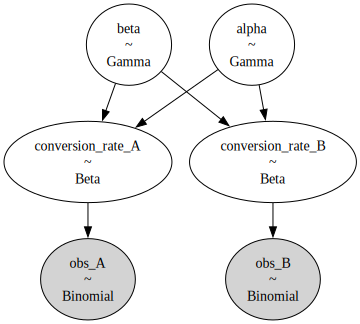

In [16]:
pm.model_to_graphviz(model_hierarchical)

In [17]:
trace2 = run_samplers(model_hierarchical)

Sampling: [alpha, beta, conversion_rate_A, conversion_rate_B, obs_A, obs_B]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, conversion_rate_A, conversion_rate_B]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs_A, obs_B]


Output()

Let's see what the hyperpriors looks like.

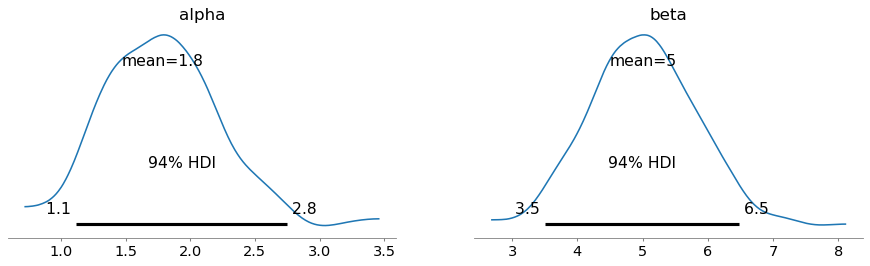

In [18]:
hyperparameters = ['alpha', 'beta']
plot_prior(trace2, var_names=hyperparameters);

The means are close to 2 and 5, which were the fixed parameters we used in the previous version.
And the priors for the conversion rates are similar to what we had before.

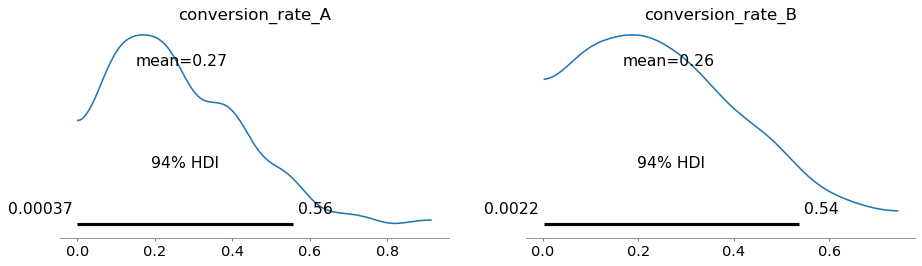

In [19]:
parameters = ['conversion_rate_A', 'conversion_rate_B']
plot_prior(trace2, var_names=parameters);

And here are the posteriors for the hyperparameters.

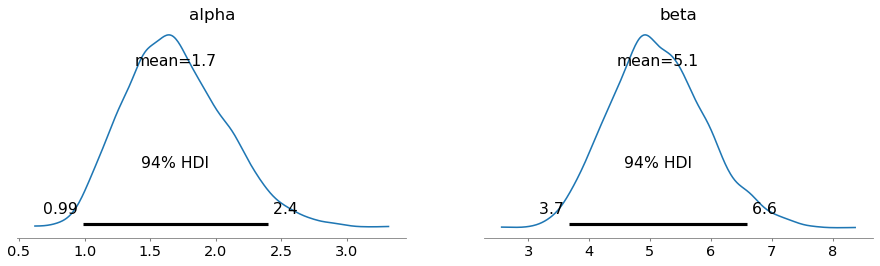

In [20]:
pm.plot_posterior(trace2, hyperparameters);

And for the conversion rates, showing the observed proportions as reference values.

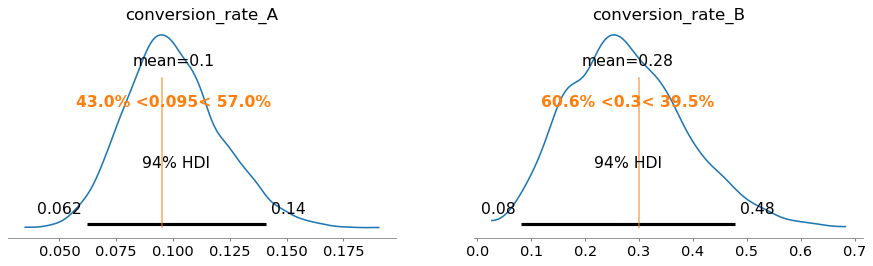

In [21]:
pm.plot_posterior(trace2, parameters, ref_val=ref_val);

In this example, the effect of the hierarchical model is small -- with more classes, we would see more interaction.

However, the hierarchical model has another useful feature: the posterior distributions of `alpha` and `beta` represent what we learned about campaigns in general, based on the results from A and B.
Together they imply a posterior belief about the conversion rate of a new, untested version, C.

First we extract the posterior distributions of the hyperparameters.

In [22]:
posterior_samples = az.extract(trace2)
alpha_samples = posterior_samples["alpha"].values
beta_samples = posterior_samples["beta"].values

Then we use them to generate a sample of possible conversion rates for an email we have never sent.

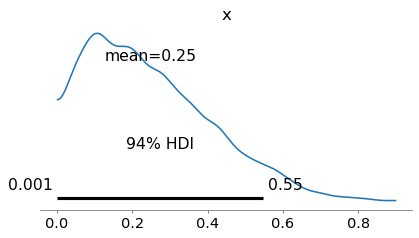

In [23]:
from scipy.stats import beta

C_samples = beta(alpha_samples, beta_samples).rvs()
pm.plot_posterior(C_samples);

Because the response rate of A is below the prior mean, the posterior mean is lower than the prior mean (0.29).

## Prediction

Notice that `run_samplers` runs:

* `pm.sample_prior_predictive`, which samples the prior and prior predictive distributions.

* `pm.sample`, which samples the posterior distribution, and

* `pm.sample_posterior_predictive`, which samples the posterior predictive distribution.

We won't talk today about the prior predictive, but let's look at the posterior predictive.

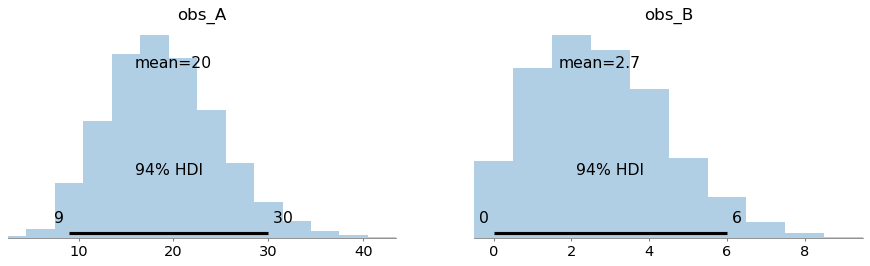

In [24]:
plot_posterior_predictive(trace2);

These distributions predict the number of conversion we expect if we run the same campaign again -- with the same values of `n` -- given our posterior beliefs about the conversion rates.

These distributions represent two sources of uncertainty:

* We don't know exactly what the conversion rates are, and

* Even if we did, we don't know how many conversions we would get.

The first is *epistemic*, because it relates to what we know.
The second is *aleatoric*, because it relates to randomness (literally "dice").

As we learn more, the first source of uncertainty gets smaller; the second does not.